In [ ]:
# https://www.kaggle.com/robertyoung/glove-twitter-pickles-27b-25d-50d-100d-200d?select=glove.twitter.27B.25d.pkl
# https://www.diycode.cc/projects/RaRe-Technologies/gensim-data

In [40]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re, string, unicodedata



from bs4 import BeautifulSoup
from helper.contractions import CONTRACTION_MAP

import inflect
import unidecode

# contactions
from pycontractions import Contractions


#!pip install pycontractions
from pycontractions import Contractions
import gensim.downloader as api

# Choose model accordingly for contractions function
model = api.load("glove-twitter-25")
# model = api.load("glove-twitter-100")
# model = api.load("word2vec-google-news-300")
cont = Contractions(kv_model=model)
cont.load_models()

# NLP libraries
import spacy
from spacy.lang.en import English

from spellchecker import SpellChecker
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[==================================================] 100.0% 104.8/104.8MB downloaded


In [39]:
#!conda install --yes seaborn
#!conda install --yes bs4
#!conda install --yes inflect
#nltk.download('stopwords')
#nltk.download('punkt')
#!conda install --yes pyemd
#!pip install pyspellchecker
#!pip install pycontractions
#!pip install spacy

In [9]:
nlp = spacy.load('en_core_web_md', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

In [21]:
## Need to investiate the slangs specific to these tweet  category

# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher',
    '****': 'Fuck',
    '*****': 'Bitch',
    'b****': 'Bitch',
    'b***h': 'Bitch',
}


### --- handle slangs
def unslang(words):
    """Convert slangs to corresponding english words"""
    slangs = []
    for word in words:
        if word.upper() in slang_abbrev_dict.keys():
            slangs.append(slang_abbrev_dict[word.upper()])
        else:
            slangs.append(word)
    return slangs

In [22]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    
    return expanded_text


##-- handle punctuations
def _remove_punct(text): 
  
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''
    for x in text.lower(): 
        if x in string.punctuation: 
            text = text.replace(x, "")
  
    return text

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(_remove_punct(word))
        
    return new_words

def remove_punctuation_old(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words


# remove whitespace from text 
def remove_whitespace(text): 
    return  " ".join(text.split())

# remove URL from text
def remove_URL(text):
    """Remove URLs from a sample string"""
    #return re.sub(r"http\S+", "", text)
    return re.sub(r'https?://www\.\S+\.com','',text)

# remove html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


##--- remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


# remove remianing non ascii characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


##-- convert text to lower case
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


##-- replace numbers with their text version
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            # extract all numbers in word and convert to word
            # replace number in word to form longer word
            other_numbers = re.findall(r'\d+', word)
            for num in other_numbers:
                new_word = " " + p.number_to_words(num) + " "
                word = word.replace(num, new_word)               
                
            new_words.append(word)
            
    return new_words


###---- Remove stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


###--- stemming
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


### --- lemmatization
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
   

### --- combine all functions to normalize text
def normalize(words):
    words = unslang(words)
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    #words = replace_numbers(words)
    #words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    words = remove_punctuation(words)
        
    return words


def preprocess(text):
    
    text = remove_URL(text)
    text = strip_html_tags(text)
    text = expand_contractions(text)
    #text = remove_emoji(text)
    
    # Tokenize
    words = nltk.word_tokenize(text)

    # Normalize
    words = normalize(words)
    
    words = ' '.join(words)
    return words


def normalize_corpus(corpus):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # pre process the text
        doc = preprocess(doc)
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [51]:
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def expand_contractions(text):
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

# Now compact all the normalization function calls into a single function
def normalization(text):
    text = expand_contractions(text)
    text = remove_accented_chars(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_punct(text)
    text = correct_spellings(text)
    return text

In [42]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv('data/sample_submission.csv')

In [47]:
train.dropna(axis=0, subset=('text', 'selected_text'), inplace=True)
test.dropna(axis=0, subset=('text', ), inplace=True)

In [43]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


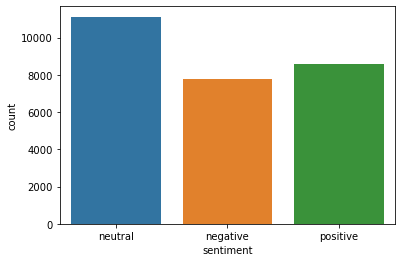

In [44]:
ax = sns.countplot(x="sentiment", data=train)

In [45]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


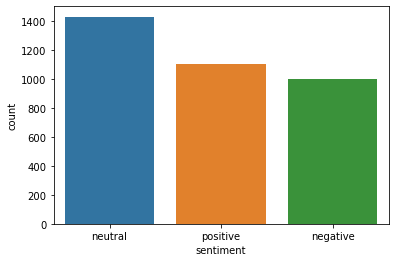

In [46]:
ax = sns.countplot(x="sentiment", data=test)

## Clean test  
1) use pycontaction inconjunction with gensim twitter pre-train model

In [53]:
#%%time
#train['text_norm'] = train['text'].apply(lambda x: normalization(x))

In [49]:
train.head()

,textID,text,selected_text,sentiment,text_norm
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,Id have responded if I were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,Sons of why could not they put them on the rel...


In [50]:
#%%time
train['selected_text_norm'] = train['selected_text'].apply(lambda x: normalization(x))

In [ ]:
#%%time
test['text_norm'] = test['text'].apply(lambda x: normalization(x))

In [28]:
#%%time
#train['text_norm'] = normalize_corpus(train.text)

#%%time
#train['selected_text_norm'] = normalize_corpus(train.selected_text)

#%%time
#test['text_norm'] = normalize_corpus(test.text)

Wall time: 23.3 s


In [57]:
cont = Contractions(api_key="glove-twitter-50")
cont.load_models()

[===============================================---] 95.1% 189.8/199.5MB downloaded

In [60]:
list(cont.expand_texts(train[train['textID'] == '4f4c4fc327']['text'], precise=True))

[' I`ve wondered about rake to.  The client has made it clear .NET only, don`t force devs to learn a new lang  #agile #ccnet']

In [32]:
train[train['textID'] == '4f4c4fc327']

,textID,text,selected_text,sentiment,text_norm,selected_text_norm
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i ve wonder about rake to the client have ma...,don t force


## EXPLORATORY DATA

In [ ]:
df = pd.concat([train,test])
df['text']=df['text'].astype(str)
df['seleceted_text']=df['selected_text'].astype(str)

In [ ]:
vals=[]
for i in range(0,3):
    x=df[df['sentiment']==sent[i]]['text'].str.len()
    vals.append(x)

fig = ff.create_distplot(vals, sent,show_hist=False)
fig.update_layout(title="Distribution of number of characters in tweets")
fig.show()